## Imports

### Import useful general libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy


### Import classes and methods from library for SPNs (spflow)

In [3]:
np.random.seed(123)

from spn.io.Graphics import plot_spn
from spn.algorithms.LearningWrappers import *
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian
from spn.structure.Base import Context, Sum, Product, Leaf, eval_spn_bottom_up, assign_ids, rebuild_scopes_bottom_up
from spn.structure.Base import *
from spn.algorithms.MPE import mpe
from spn.algorithms.Inference import log_likelihood, likelihood, prod_likelihood, _node_likelihood

### Import data

In [4]:
file_path = 'C:/Users/loumo/OneDrive/Documents/Academique/ANDROIDE/M2/MADI/Projet/Dataset/optdigits.tra'

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

print(df.head())  # Display the first few rows of the DataFrame

   0  1   6  15  12  1.1  0.1  0.2  0.3  7  ...  0.21  0.22  0.23  6.3  14.1  \
0  0  0  10  16   6    0    0    0    0  7  ...     0     0     0   10    16   
1  0  0   8  15  16   13    0    0    0  1  ...     0     0     0    9    14   
2  0  0   0   3  11   16    0    0    0  0  ...     0     0     0    0     1   
3  0  0   5  14   4    0    0    0    0  0  ...     0     0     0    4    12   
4  0  0  11  16  10    1    0    0    0  4  ...     3     0     0   10    16   

   7.4  1.3  0.24  0.25  0.26  
0   15    3     0     0     0  
1    0    0     0     0     7  
2   15    2     0     0     4  
3   14    7     0     0     6  
4   16   16    16     6     2  

[5 rows x 65 columns]


In [5]:
file_path = 'C:/Users/loumo/OneDrive/Documents/Academique/ANDROIDE/M2/MADI/Projet/Dataset/optdigits.tes'

# Read the CSV file into a Pandas DataFrame
df_test = pd.read_csv(file_path)

In [32]:
test_data = df_test.values
#print(test_data)
print(np.shape(test_data))
test_data_no_class = np.ones((1796,65))*np.nan
test_data_no_class[:,:64] = test_data[:,:64]
print(test_data_no_class)

(1796, 65)
[[ 0.  0.  0. ...  0.  0. nan]
 [ 0.  0.  0. ...  9.  0. nan]
 [ 0.  0.  7. ...  0.  0. nan]
 ...
 [ 0.  0.  1. ...  0.  0. nan]
 [ 0.  0.  2. ...  0.  0. nan]
 [ 0.  0. 10. ...  1.  0. nan]]


## Learn SPN

In [7]:
dom = np.asanyarray([[i for i in range(17)]]*65)

In [8]:
train_data = df.values
spn_classification = learn_classifier(
    train_data,
    Context(domains=dom, parametric_types=[Categorical]*65), 
    spn_learn_wrapper=learn_parametric, label_idx=64)

c:\Users\loumo\anaconda3\envs\madi_env\Lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\loumo\anaconda3\envs\madi_env\Lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\loumo\anaconda3\envs\madi_env\Lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\loumo\anaconda3\envs\madi_env\Lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\loumo\anaconda3\envs\madi_env\Lib\site-packages\sklearn\cross_decom

#### Comprendre la structure du SPN appris

<module 'matplotlib.pyplot' from 'c:\\Users\\loumo\\anaconda3\\envs\\madi_env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

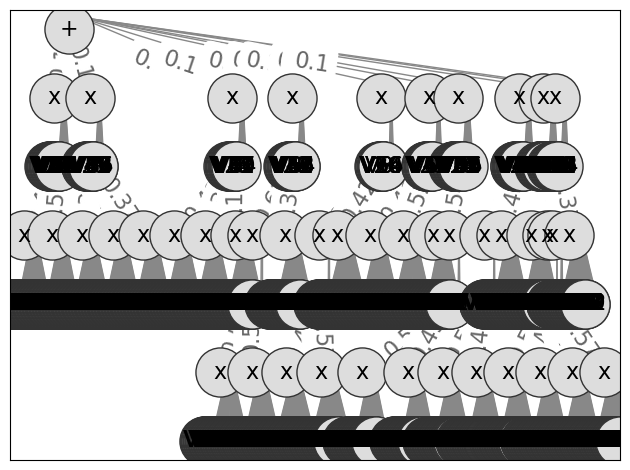

In [9]:
from spn.io.Graphics import draw_spn

draw_spn(spn_classification)

In [10]:
dict_node_types = get_node_types(spn_classification)  # get types of nodes in a subtree
print(dict_node_types)

nb_edges = get_number_of_edges(spn_classification)
print(nb_edges)

nb_nodes = get_number_of_nodes(spn_classification)
print(nb_nodes)

depth = get_depth(spn_classification)
print(depth)


{<class 'spn.structure.Base.Sum'>, <class 'spn.structure.leaves.parametric.Parametric.Categorical'>, <class 'spn.structure.Base.Product'>}
1640
1641
7


In [11]:
depth = get_depth(spn_classification.children[0])
print(depth)

4


#### Prédiction avec le SPN appris

In [12]:
pred_im = mpe(spn_classification, test_data_no_class)
print(test_data_no_class)

c:\Users\loumo\anaconda3\envs\madi_env\Lib\site-packages\spn\structure\leaves\parametric\Inference.py:88: RuntimeWarning: divide by zero encountered in log
  probs[idx_in] = np.array(np.log(node.p))[cat_data[~out_domain_ids]]


[[ 0.  0.  0. ...  0.  0. nan]
 [ 0.  0.  0. ...  9.  0. nan]
 [ 0.  0.  7. ...  0.  0. nan]
 ...
 [ 0.  0.  1. ...  0.  0. nan]
 [ 0.  0.  2. ...  0.  0. nan]
 [ 0.  0. 10. ...  1.  0. nan]]


#### Accuracy

In [13]:
nb_im = 1796
nb_err = np.where(pred_im==test_data,0,1).sum()
acc = (nb_im-nb_err)/nb_im
print(acc)

0.6648106904231625


## Learn CSPN

### Epsilon-contamination

In [14]:
import copy

def eps_contamination(spn, eps):
    '''
    Updates the weights of an SPN with epsilon-contamination at the node spn.
    Parameters
    -------------
    Entrées : spn : SPN ; eps : float
    Sortie : CSPN
    '''
    if isinstance(spn, Sum):
        lw = len(spn.weights)
        for i in range(lw):
            if not(isinstance(spn.weights[i], list)):         # Si l'arête n'a pas déjà été 'crédalisée'
                spn.weights[i] = [(1-eps)*spn.weights[i], (1-eps)*spn.weights[i] + eps]
                for child in spn.children:
                    eps_contamination(child, eps)
    elif isinstance(spn, Product):
        for child in spn.children:
            eps_contamination(child, eps)
    return spn

def cspn_from_spn(spn, eps):
    '''
    Produces a CSPN from an SPN with epsilon-contamination by calling recursively spn_to_cspn
    Parameters
    -------------
    Entrées : spn : SPN ; eps : float
    Sortie : CSPN
    '''
    c_spn = copy.deepcopy(spn)
    return eps_contamination(c_spn, eps)

In [15]:
cspn = cspn_from_spn(spn_classification, 0.1)

## Adaptation du calcul de la vraisemblance

Il faut résoudre un programme linéaire lorsque l'on rencontre un noeud SOMME :

\begin{equation}
\begin{aligned}
\min \sum_j w_{ij} L^j(\lambda)\\
s.c. \quad w_i \in C_i
\end{aligned}   
\end{equation}

In [16]:
def likelihood_cspn_borne(cspn, x, borne="min"):
    '''
    Calcule la vraisemblance min (ou max) d'une réalisation x des variables dans le cspn (arbre ou sous-arbre) 
    (comme expliqué dans l'article à la section 4)
    Paramètres
    ------------
    Entrées : cspn ; réalisation x : vecteur de taille nombre de feuilles ; borne : string ("min" ou "max")
    Sortie : vraisemblance : float np.array de dim 2 (min et max likelihood)
    '''
    if isinstance(cspn, Leaf):
        variable = cspn.scope    # Leaf nodes have an attribute scope corresponding to the variable they represent (list of one element), other nodes 
        # have an attribute scope which is a list of the variables represented by the leaf nodes they are connected to.
        pass
    elif isinstance(cspn, Product):
        m = 1
        for child in cspn.children:
            m *= likelihood_cspn_borne(child, x, borne)
    elif isinstance(cspn, Sum):
        if borne=="min":
            pass # Résoudre le programme linéaire de l'article
        elif borne=="max":
            pass # Résoudre autre programme linéaire
    return m

In [17]:
import copy

print(test_data_no_class)
test_classification = test_data_no_class[0].reshape(-1,test_data_no_class[1].shape[0])
print(test_classification)


[[ 0.  0.  0. ...  0.  0. nan]
 [ 0.  0.  0. ...  9.  0. nan]
 [ 0.  0.  7. ...  0.  0. nan]
 ...
 [ 0.  0.  1. ...  0.  0. nan]
 [ 0.  0.  2. ...  0.  0. nan]
 [ 0.  0. 10. ...  1.  0. nan]]
[[ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
   3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
  16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
   0.  0.  0.  0.  0. 11. 16. 10.  0.  0. nan]]


In [18]:
def lower_sum_likelihood(node, children, dtype=np.float64, **kwargs):
    c = copy.deepcopy(children)
    c = np.ravel(c).tolist()
    A_eq = [np.ravel([1 for i in node.weights]).tolist()]
    b_eq = [1]
    res = scipy.optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=[(w[0], w[1]) for w in node.weights])
    return np.array(res.fun).reshape(1,1)

_lower_node_likelihood = _node_likelihood.copy()
_lower_node_likelihood[Sum] = lower_sum_likelihood

lcll = likelihood(cspn, test_classification, node_likelihood = _lower_node_likelihood)
print('Lower likelihood :', lcll)

print('Likelihood :', likelihood(spn_classification, test_classification))

def upper_sum_likelihood(node, children, dtype=np.float64, **kwargs):
    c = copy.deepcopy(children)
    c = (-np.ravel(c)).tolist()
    A_eq = [np.ravel([1 for i in node.weights]).tolist()]
    b_eq = [1]
    res = scipy.optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=[(w[0], w[1]) for w in node.weights])
    return np.array(-res.fun).reshape(1,1)

_upper_node_likelihood = _node_likelihood.copy()
_upper_node_likelihood[Sum] = upper_sum_likelihood

ucll = likelihood(cspn, test_classification, node_likelihood = _upper_node_likelihood)
print('Upper likelihood :', ucll)

Lower likelihood : [[7.12833779e-33]]
Likelihood : [[8.80041686e-33]]
Upper likelihood : [[7.12833779e-33]]


### Interval-dominance classification

In [87]:
def interval_dom(cspn, data, c1, c2):
    '''
    Renvoie True si la classe c1 domine par intervalle la classe c2.
    Paramètres
    ------------
    Entrées : 
    - cspn 
    - data : réalisation (sans la donnée de classe) 
    - c1, c2 : indices de classe
    Sortie : Booléen 
    '''
    data_c1 = data.reshape(-1, data.shape[0])
    data_c1[0,-1] = c1
    #print("data-c1",data_c1)
    l_c1, u_c1 = likelihood(cspn, data_c1, node_likelihood = _lower_node_likelihood), likelihood(cspn, data_c1, node_likelihood = _upper_node_likelihood)
    #l1 = likelihood(spn_classification, data_c1)
    print("c1", l_c1, u_c1)
    #print("likelihood1",l1)
    data_c2 = data.reshape(-1, data.shape[0])
    data_c2[0,-1] = c2
    #print("data-c2",data_c2)
    l_c2, u_c2 = likelihood(cspn, data_c2, node_likelihood = _lower_node_likelihood), likelihood(cspn, data_c2, node_likelihood = _upper_node_likelihood)
    print("c2", l_c2, u_c2)
    #l2 = likelihood(spn_classification, data_c2)
    #print("likelihood2",l2)

    return bool(l_c1 > u_c2)

In [88]:
test_data = df_test.values
#print(test_data)
print(np.shape(test_data))
test_data_no_class = np.ones((1796,65))*np.nan
test_data_no_class[:,:64] = test_data[:,:64]
print(test_data_no_class)
test_classification = test_data_no_class[1].reshape(-1,test_data_no_class[1].shape[0])

(1796, 65)
[[ 0.  0.  0. ...  0.  0. nan]
 [ 0.  0.  0. ...  9.  0. nan]
 [ 0.  0.  7. ...  0.  0. nan]
 ...
 [ 0.  0.  1. ...  0.  0. nan]
 [ 0.  0.  2. ...  0.  0. nan]
 [ 0.  0. 10. ...  1.  0. nan]]


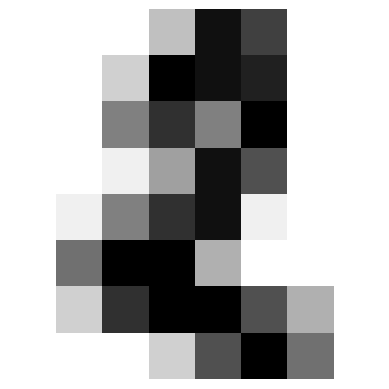

0.0
[[0.]] [[-0.]]
c1 [[0.]] [[-0.]]
c2 [[0.]] [[-0.]]
False
[[0.]] [[-0.]]
c1 [[0.]] [[-0.]]
c2 [[0.]] [[-0.]]
False
[[0.]] [[-0.]]
c1 [[0.]] [[-0.]]
c2 [[0.]] [[-0.]]
False
[[0.]] [[-0.]]
c1 [[0.]] [[-0.]]
c2 [[0.]] [[-0.]]
False
[[0.]] [[-0.]]
c1 [[0.]] [[-0.]]
c2 [[0.]] [[-0.]]
False
[[0.]] [[-0.]]
c1 [[0.]] [[-0.]]
c2 [[0.]] [[-0.]]
False
[[0.]] [[-0.]]
c1 [[0.]] [[-0.]]
c2 [[0.]] [[-0.]]
False
[[0.]] [[-0.]]
c1 [[0.]] [[-0.]]
c2 [[0.]] [[-0.]]
False
[[0.]] [[-0.]]
c1 [[0.]] [[-0.]]
c2 [[0.]] [[-0.]]
False


In [92]:
i = 1
im0 = test_data[i][:64]
im0 = im0.reshape((8,8))
import matplotlib.pyplot as plt
im0 = 16-im0
# Afficher l'image en niveaux de gris
plt.imshow(im0, cmap='gray')
plt.axis('off')  # Désactiver les axes
plt.show()
#print(test_data_no_class)
data = copy.deepcopy(test_data_no_class)
c = mpe(spn_classification, data)[i,-1]
print(c)
for j in range(9):
    data = copy.deepcopy(test_data_no_class[i])
    data_c1 = data.reshape(-1, data.shape[0])
    data_c1[0,-1] = j
    #print(data_c1)
    l_c1, u_c1 = likelihood(cspn, data_c1, node_likelihood = _lower_node_likelihood), likelihood(cspn, data_c1, node_likelihood = _upper_node_likelihood)
    print(l_c1,u_c1)
    data = copy.deepcopy(test_data_no_class[i])
    print(interval_dom(cspn, data, c, 0))


In [ ]:
print(test_data_no_class)

[[ 0.  0.  0. ...  0.  0. nan]
 [ 0.  0.  0. ...  9.  0. nan]
 [ 0.  0.  7. ...  0.  0. nan]
 ...
 [ 0.  0.  1. ...  0.  0. nan]
 [ 0.  0.  2. ...  0.  0. nan]
 [ 0.  0. 10. ...  1.  0. nan]]


In [44]:
def robustness_interval(cspn, data, c1, eps=None):
    if eps == None:
        eps = 0.001
        while eps < 0.5:
            if 
        while interval_dom(cspn, data, c1, c2) for c2 in 

SyntaxError: invalid syntax (4084603226.py, line 5)